In [162]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import tensorflow as tf

import cv2
import matplotlib
from subprocess import check_output
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [163]:
def int_to_classes(i):
    if i == 0: 
        return "No Diabetic Retinopathy diseases"
    elif i == 1: 
        return "Mild"
    elif i == 2: 
        return "Moderate"
    elif i == 3: 
        return "Severe"
    elif i == 4: 
        return "Proliferative DR"
    print("NO class exist ", i)
    return "No Class exist"

In [164]:

NUM_CLASSES = 5
# we need images of same size so we convert them into the size
WIDTH = 128
HEIGHT = 128
DEPTH = 3
inputShape = (HEIGHT, WIDTH, DEPTH)
# initialize number of epochs to train for, initial learning rate and batch size
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
#global variables
ImageNameDataHash = {}
uniquePatientIDList = []

In [165]:

def readTrainData(trainDir):
    global ImageNameDataHash
    # loop over the input images
    images = os.listdir(trainDir)
    
    print("Number of files in " + trainDir + " is " + str(len(images)))
    for imageFileName in images:
        if (imageFileName == "trainLabels.csv"):
            continue
        # load the image, pre-process it, and store it in the data list
       
        
        img = load_img(imageFileName)
        arr = img_to_array(img)  # Numpy array with shape (233,233,3)
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
       
        if (dim1 < HEIGHT or dim2 < WIDTH or dim3 < DEPTH):
            print("Error image dimensions are less than expected "+str(arr.shape))
        arr = cv2.resize(arr, (HEIGHT,WIDTH)) #Numpy array with shape (HEIGHT, WIDTH,3)
    
      
        dim1 = arr.shape[0]
        dim2 = arr.shape[1]
        dim3 = arr.shape[2]
        if (dim1 != HEIGHT or dim2 != WIDTH or dim3 != DEPTH):
            print("Error after resize, image dimensions are not equal to expected "+str(arr.shape))
        #print(type(arr))
        # scale the raw pixel intensities to the range [0, 1] - TBD TEST
        arr = np.array(arr, dtype="float") / 255.0
        imageFileName = imageFileName.replace('.jpeg','')
        ImageNameDataHash[str(imageFileName)] = np.array(arr) 
    return

from datetime import datetime
print("Loading images at..."+ str(datetime.now()))
readTrainData('train')
print("Loaded " + str(len(ImageNameDataHash)) + " images at..."+ str(datetime.now())) # 1000


Loading images at...2022-11-24 20:15:22.209105
Number of files in train is 2000
Loaded 2000 images at...2022-11-24 20:18:49.895269


In [166]:
#csv contains image	level
#10_left 0
#10_right 0
import csv
def readTrainCsv():
    raw_df = pd.read_csv('trainLabels.csv', sep=',')
    print(type(raw_df)) #<class 'pandas.core.frame.DataFrame'>
    row_count=raw_df.shape[0] #gives number of row count row_count=35126 
    col_count=raw_df.shape[1] #gives number of col count col count=2
    print("row_count="+str(row_count)+" col count="+str(col_count))
    raw_df["PatientID"] = ''
    header_list = list(raw_df.columns)
    print(header_list) # ['image', 'level', 'PatientID']
    # double check if level of left and right are same or not
    ImageLevelHash = {}
    patientIDList = []
    for index, row in raw_df.iterrows():
        # 0 is image, 1 is level, 2 is PatientID, 3 is data
        key = row[0] + ''
        patientID = row[0] + ''
        patientID = patientID.replace('_right','')
        patientID = patientID.replace('_left','')
        #print("Adding patient ID"+ patientID)
        raw_df.at[index, 'PatientID'] = patientID
        patientIDList.append(patientID)
        ImageLevelHash[key] = str(row[1]) # level
                
    global uniquePatientIDList
    uniquePatientIDList = sorted(set(patientIDList))
    count=0;
    for patientID in uniquePatientIDList:
        left_level = ImageLevelHash[str(patientID+'_left')]
        right_level = ImageLevelHash[str(patientID+'_right')]
        #right_exists = str(patientID+'_right') in raw_df.values
        if (left_level != right_level):
            count = count+1
            #print("Warning for patient="+ str(patientID) + " left_level=" + left_level+ " right_level=" +right_level)
    print("count of images with both left and right eye level not matching="+str(count)) # 2240
    print("number of unique patients="+str(len(uniquePatientIDList))) # 17563
    return raw_df

In [167]:
random.seed(10)
print("Reading trainLabels.csv...")
df = readTrainCsv()

Reading trainLabels.csv...
<class 'pandas.core.frame.DataFrame'>
row_count=35126 col count=2
['image', 'level', 'PatientID']
count of images with both left and right eye level not matching=2240
number of unique patients=17563


In [168]:
for i in range(0,10):
    s = df.loc[df.index[i], 'PatientID'] # get patient id of patients
    print(str(i) + " patient's patientID="+str(s))

0 patient's patientID=10
1 patient's patientID=10
2 patient's patientID=13
3 patient's patientID=13
4 patient's patientID=15
5 patient's patientID=15
6 patient's patientID=16
7 patient's patientID=16
8 patient's patientID=17
9 patient's patientID=17


In [169]:
# df has 3 columns ['image', 'level', 'PatientID']
keepImages =  list(ImageNameDataHash.keys())
df = df[df['image'].isin(keepImages)]
print(len(df)) # 1000

2000


In [170]:
#convert hash to dataframe
imageNameArr = []
dataArr = []
for index, row in df.iterrows():
    key = str(row[0])
    if key in ImageNameDataHash:
        imageNameArr.append(key)
        dataArr.append(np.array(ImageNameDataHash[key])) # np.array

df2 = pd.DataFrame({'image': imageNameArr, 'data': dataArr})
df2_header_list = list(df2.columns) 
print(df2_header_list) # ['image', 'data']
print(len(df2)) # 1000
#print(df2.describe(include='all'))
#print(df2.sample(3)) # 3 rows x 2 columns

['image', 'data']
2000


In [171]:
if len(df) != len(df2):
    print("Error length of df != df2")
    
for idx in range(0,len(df)):
    if (df.loc[df.index[idx], 'image'] != df2.loc[df2.index[idx], 'image']):
        print("Error " + df.loc[df.index[idx], 'image'] +"==" + df2.loc[df2.index[idx], 'image'])
        
print(df2.dtypes)
print(df.dtypes)

image    object
data     object
dtype: object
image        object
level         int64
PatientID    object
dtype: object


In [172]:
df = pd.merge(df2, df, left_on='image', right_on='image', how='outer')
df_header_list = list(df.columns) 
print(df_header_list) # 'image', 'data', level', 'PatientID'
print(len(df)) # 1000
print(df.sample())

['image', 'data', 'level', 'PatientID']
2000
           image                                               data  level  \
899  10125_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      3   

    PatientID  
899     10125  


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
<class 'numpy.ndarray'>
(128, 128, 3)
Sample Image


C:\Users\saksh\AppData\Local\Temp/ipykernel_1040/17685004.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


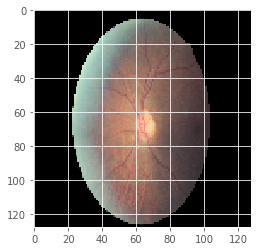

In [173]:
sample0 = df.loc[df.index[0], 'data']
print(sample0)
print(type(sample0)) # <class 'numpy.ndarray'>
print(sample0.shape) # 128,128,3
from matplotlib import pyplot as plt
plt.imshow(sample0, interpolation='nearest')
plt.show()
print("Sample Image")

In [174]:
X = df['data']
Y = df['level']
# scale the raw pixel intensities to the range [0, 1]
#print(type(X)) # 'pandas.core.series.Series'
#X = np.array(X, dtype="float") / 255.0 -- TBD moved to top
Y = np.array(Y)
# convert the labels from integers to vectors
Y =  to_categorical(Y, num_classes=NUM_CLASSES)

In [175]:
# partition the data into training and testing splits using 75% training and 25% for validation
print("Parttition data into 75:25...")
sys.stdout.flush()
print("Unique patients in dataframe df=" + str(df.PatientID.nunique())) # 500
unique_ids = df.PatientID.unique()
print('unique_ids shape='+ str(len(unique_ids))) #500

# Refer https://www.kaggle.com/kmader/tf-data-tutorial-with-retina-and-keras
train_ids, valid_ids = train_test_split(unique_ids, test_size = 0.25, random_state = 10) #stratify = rr_df['level'])
trainid_list = train_ids.tolist()
print('trainid_list shape=', str(len(trainid_list))) # 375

traindf = df[df.PatientID.isin(trainid_list)]
valSet = df[~df.PatientID.isin(trainid_list)]

Parttition data into 75:25...
Unique patients in dataframe df=1000
unique_ids shape=1000
trainid_list shape= 750


In [176]:
print(traindf.head())
print(valSet.head())

traindf = traindf.reset_index(drop=True)
valSet = valSet.reset_index(drop=True)

print(traindf.head())
print(valSet.head())

      image                                               data  level  \
0   10_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
1  10_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
4   15_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      1   
5  15_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      2   
6   16_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      4   

  PatientID  
0        10  
1        10  
4        15  
5        15  
6        16  
        image                                               data  level  \
2     13_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
3    13_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
12   102_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0022058...      0   
13  102_right  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   
22   115_left  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...      0   

   PatientID  
2         1

In [177]:
trainX = traindf['data']
trainY = traindf['level']

valX = valSet['data']
valY = valSet['level']

#(trainX, valX, trainY, valY) = train_test_split(X,Y,test_size=0.25, random_state=10)
print('trainX shape=', trainX.shape[0], 'valX shape=', valX.shape[0]) # 750, 250

trainX shape= 1500 valX shape= 500


In [178]:
trainY =  to_categorical(trainY, num_classes=NUM_CLASSES)
valY =  to_categorical(valY, num_classes=NUM_CLASSES)

In [179]:
#construct the image generator for data augmentation
print("Generating images...")
sys.stdout.flush()
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

Generating images...


In [180]:
def createModel():
    model = Sequential()
    # first set of CONV => RELU => MAX POOL layers
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=inputShape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    # returns our fully constructed deep learning + Keras image classifier 
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    # use binary_crossentropy if there are two classes
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [181]:
print("Reshaping trainX at..."+ str(datetime.now()))
#print(trainX.sample()) 
print(type(trainX)) # <class 'pandas.core.series.Series'>
print(trainX.shape) # (750,)
from numpy import zeros
Xtrain = np.zeros([trainX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(trainX.shape[0]): # 0 to traindf Size -1
    Xtrain[i] = trainX[i]
print(Xtrain.shape) # (750,128,128,3)
print("Reshaped trainX at..."+ str(datetime.now()))

Reshaping trainX at...2022-11-24 20:19:05.393912
<class 'pandas.core.series.Series'>
(1500,)
(1500, 128, 128, 3)
Reshaped trainX at...2022-11-24 20:19:05.490907


In [182]:
print("Reshaping valX at..."+ str(datetime.now()))
print(type(valX)) # <class 'pandas.core.series.Series'>
print(valX.shape) # (250,)
from numpy import zeros
Xval = np.zeros([valX.shape[0],HEIGHT, WIDTH, DEPTH])
for i in range(valX.shape[0]): # 0 to traindf Size -1
    Xval[i] = valX[i]
print(Xval.shape) # (250,128,128,3)
print("Reshaped valX at..."+ str(datetime.now()))

Reshaping valX at...2022-11-24 20:19:05.504037
<class 'pandas.core.series.Series'>
(500,)
(500, 128, 128, 3)
Reshaped valX at...2022-11-24 20:19:05.539943


In [183]:
# initialize the model
print("compiling model...")
model = createModel()

# print the summary of model
#from keras.utils import print_summary
#print_summary(model, line_length=None, positions=None, print_fn=None)
model.summary()

#add some visualization
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

compiling model...
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None,

C:\Users\saksh\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [184]:
# train the network
print("training network...")
sys.stdout.flush()
#class_mode ='categorical', # 2D one-hot encoded labels
H = model.fit_generator(aug.flow(Xtrain, trainY, batch_size=BS), \
    validation_data=(Xval, valY), \
    validation_steps = len(Xval) // BS,steps_per_epoch=len(trainX) // BS, \
    epochs=EPOCHS, verbose=1)
print("testing network...")
T = model.evaluate(aug.flow(Xval, valY, batch_size=BS))


# save the model to disk
print("Saving model to disk")
model.save("/tmp/mymodel")

training network...


C:\Users\saksh\AppData\Local\Temp/ipykernel_1040/763181085.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(aug.flow(Xtrain, trainY, batch_size=BS), \


Epoch 1/15
46/46 [==============================] - 21s 456ms/step - loss: 0.9983 - accuracy: 0.7050 - val_loss: 0.9783 - val_accuracy: 0.7380
Epoch 2/15
46/46 [==============================] - 20s 443ms/step - loss: 0.9166 - accuracy: 0.7173 - val_loss: 0.9283 - val_accuracy: 0.7380
Epoch 3/15
46/46 [==============================] - 22s 484ms/step - loss: 0.9030 - accuracy: 0.7200 - val_loss: 0.8811 - val_accuracy: 0.7380
Epoch 4/15
46/46 [==============================] - 22s 481ms/step - loss: 0.8896 - accuracy: 0.7228 - val_loss: 0.9589 - val_accuracy: 0.7380
Epoch 5/15
46/46 [==============================] - 20s 439ms/step - loss: 0.8900 - accuracy: 0.7214 - val_loss: 0.8926 - val_accuracy: 0.7380
Epoch 6/15
46/46 [==============================] - 20s 444ms/step - loss: 0.8824 - accuracy: 0.7187 - val_loss: 0.8765 - val_accuracy: 0.7380
Epoch 7/15
46/46 [==============================] - 20s 439ms/step - loss: 0.9029 - accuracy: 0.7193 - val_loss: 0.8976 - val_accuracy: 0.7380

INFO:tensorflow:Assets written to: /tmp/mymodel\assets


INFO:tensorflow:Assets written to: /tmp/mymodel\assets


Generating plots...


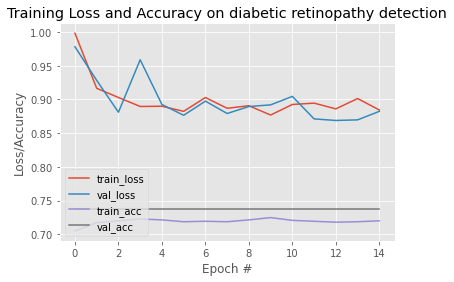

In [185]:
# set the matplotlib backend so figures can be saved in the background
# plot the training loss and accuracy
print("Generating plots...")
sys.stdout.flush()
matplotlib.use("Agg")
matplotlib.pyplot.style.use("ggplot")
matplotlib.pyplot.figure()
N = EPOCHS
matplotlib.pyplot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
matplotlib.pyplot.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
matplotlib.pyplot.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
matplotlib.pyplot.title("Training Loss and Accuracy on diabetic retinopathy detection")
matplotlib.pyplot.xlabel("Epoch #")
matplotlib.pyplot.ylabel("Loss/Accuracy")
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.savefig("plot.png")